In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

   
# Read in cars and notcars
cars = glob.glob('data/vehicles/**/*.png', recursive=True)
notcars = glob.glob('data/non-vehicles/**/*.png', recursive=True)

print('found %d cars' % len(cars))
print('found %d non-cars' % len(notcars))

found 0 cars
found 0 non-cars


D:\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [67]:
# Reduce the sample size
#sample_size = 1000
sample_size = -1
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 18  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, None] # Min and max in y to search in slide_window()


car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()


Using: 18 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 11400
0.47 Seconds to train SVC...
Test Accuracy of SVC =  1.0


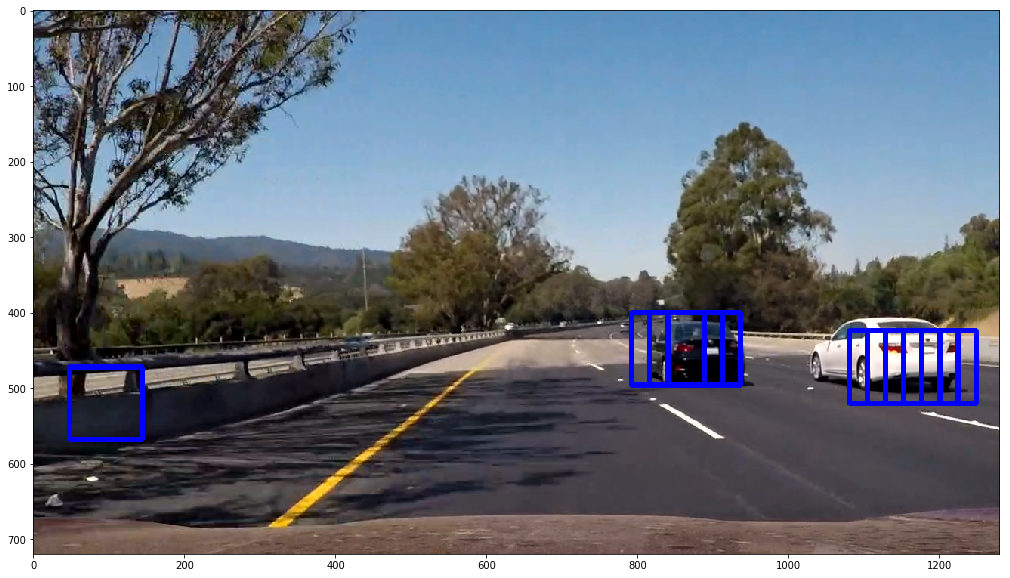

In [68]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    boxes = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            features = np.concatenate((spatial_features, hist_features, hog_features)).reshape(1, -1)
            #features = np.vstack((features)).astype(np.float64)
            
            #test_features = X_scaler.transform(np.hstack(features).reshape(1, -1))    
            test_features = X_scaler.transform(features)   
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                ul, br =(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)
                boxes.append((ul, br))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img, boxes
    
ystart = 400
ystop = 656
scale = 1.5
image = mpimg.imread('output_images/test_21.jpg')

out_img, boxes = find_cars(image, ystart, ystop, scale, svc, 
                           X_scaler, orient, pix_per_cell, 
                           cell_per_block, spatial_size, hist_bins)

plt.figure(figsize=(20,10))
plt.imshow(out_img)
plt.show()


400 656 2.5 LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0) StandardScaler(copy=True, with_mean=True, with_std=True) 18 8 2 (16, 16) 16
found 2 boxes


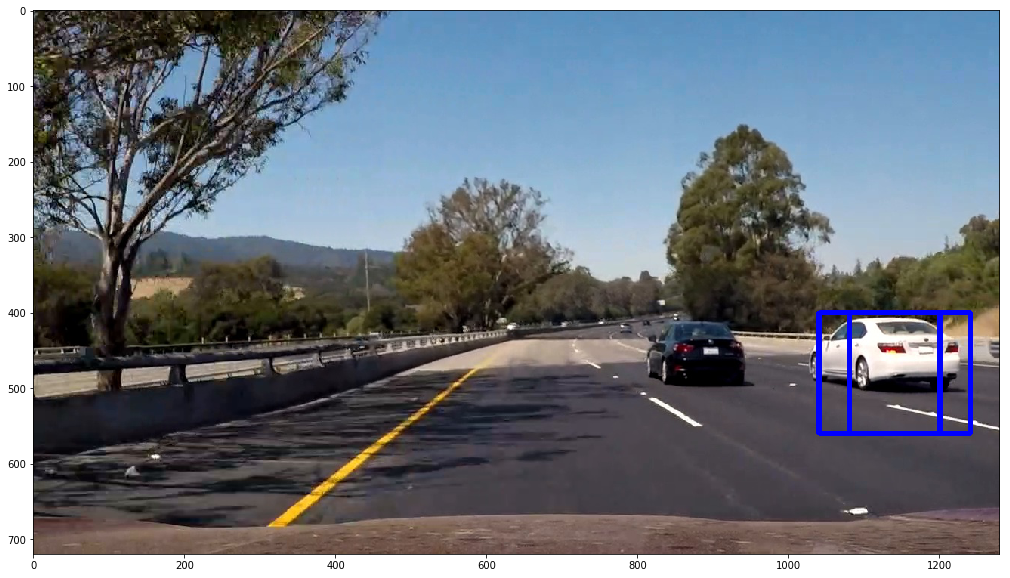

In [69]:
ystart = 400
ystop = 656
scale = 2.5

image = mpimg.imread('output_images/test_20.jpg')

print(ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

out_img, boxes = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

print('found', len(boxes), 'boxes')
plt.figure(figsize=(20,10))
plt.imshow(out_img)
plt.show()

In [15]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


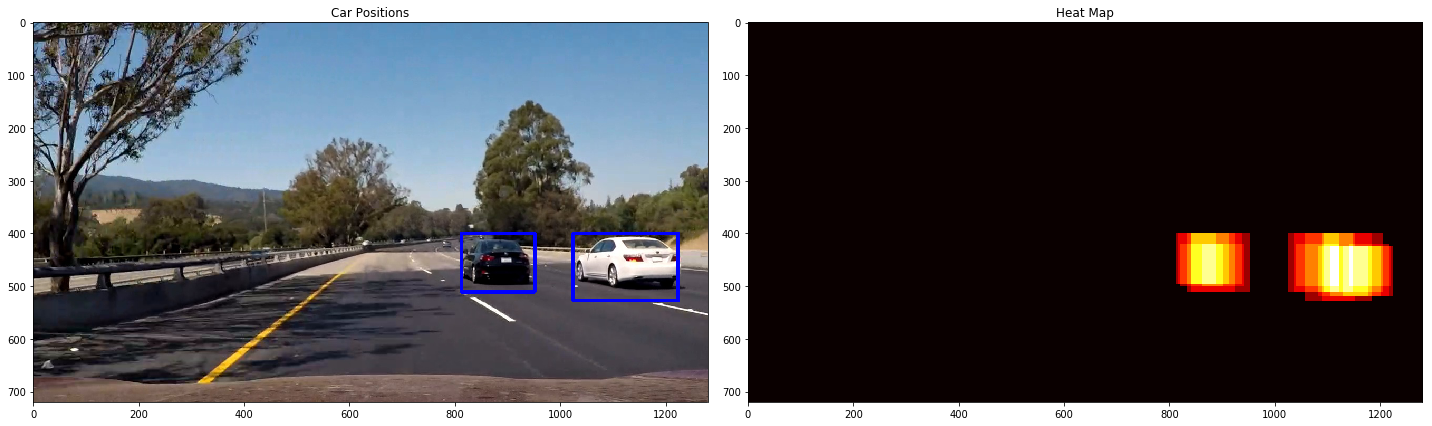

In [91]:
from scipy.ndimage.measurements import label

def draw_cars_heat(image, debug=False):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    orient = 18  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    ystart = 400
    ystop = 656
    scales = (1.0, 1.25, 1.5, 1.75, 2.0)

    all_boxes = []

    for scale in scales:

        img, box_list = find_cars(image, 
                                  ystart, 
                                  ystop, 
                                  scale, 
                                  svc, 
                                  X_scaler, 
                                  orient, 
                                  pix_per_cell, 
                                  cell_per_block, 
                                  spatial_size, 
                                  hist_bins)


        # Add heat to each box in box list
        heat = add_heat(heat, box_list)

        #print('found', len(box_list), 'boxes at scale', scale)

        all_boxes = all_boxes + box_list

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    if debug:
        fig = plt.figure(figsize=(20,10))
        plt.subplot(121)
        plt.imshow(draw_img)
        plt.title('Car Positions')
        plt.subplot(122)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map')
        fig.tight_layout()
        plt.show()
        
    return draw_img

image = mpimg.imread('output_images/test_21.jpg')
res_img = draw_cars_heat(image, True)

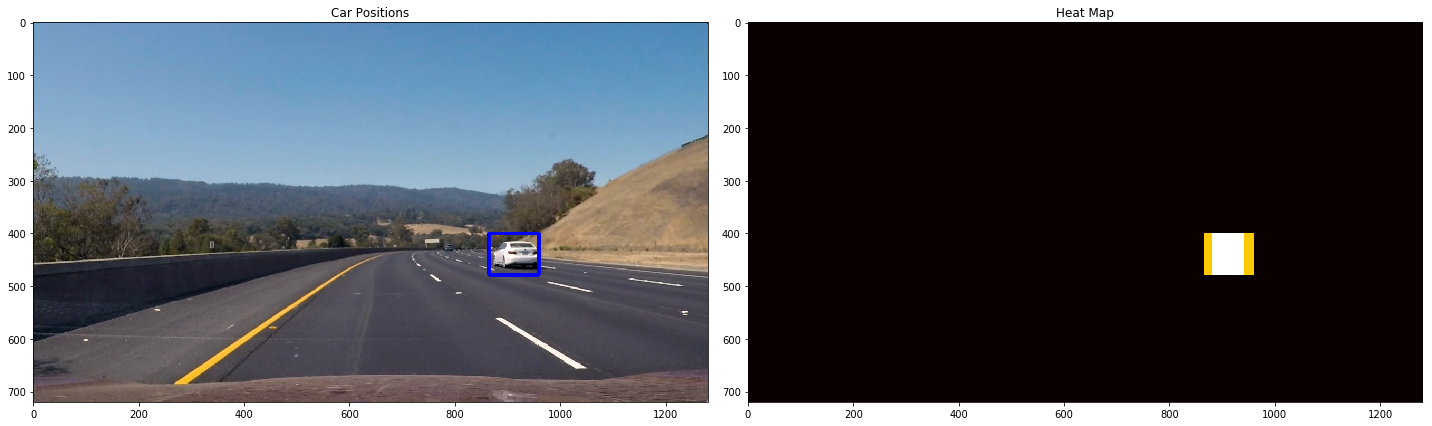

In [86]:
image = mpimg.imread('test_images/test3.jpg')
res_img = draw_cars_heat(image, True)

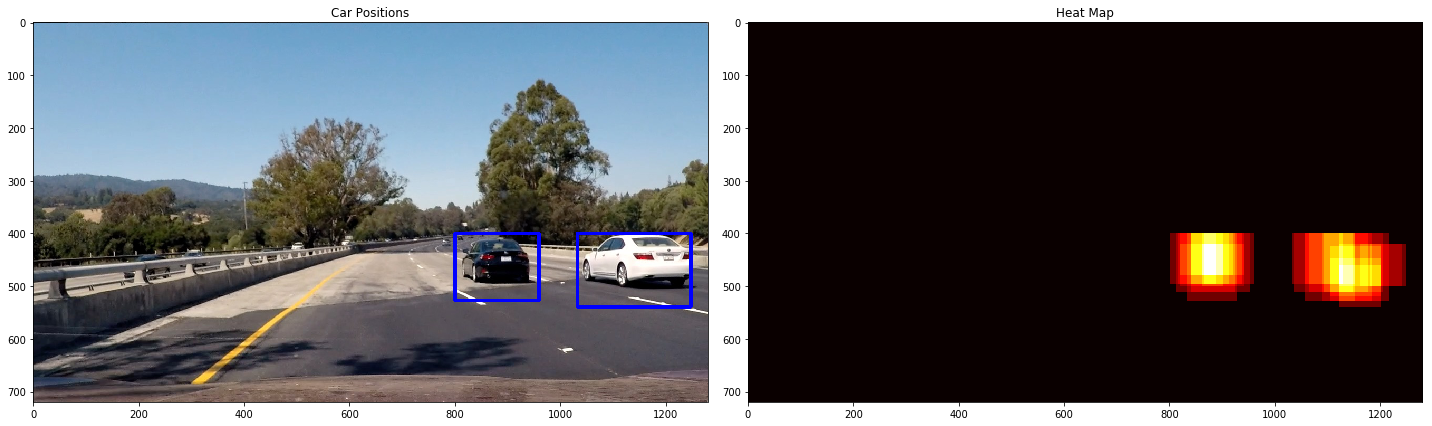

In [87]:
image = mpimg.imread('test_images/test4.jpg')
res_img = draw_cars_heat(image, True)

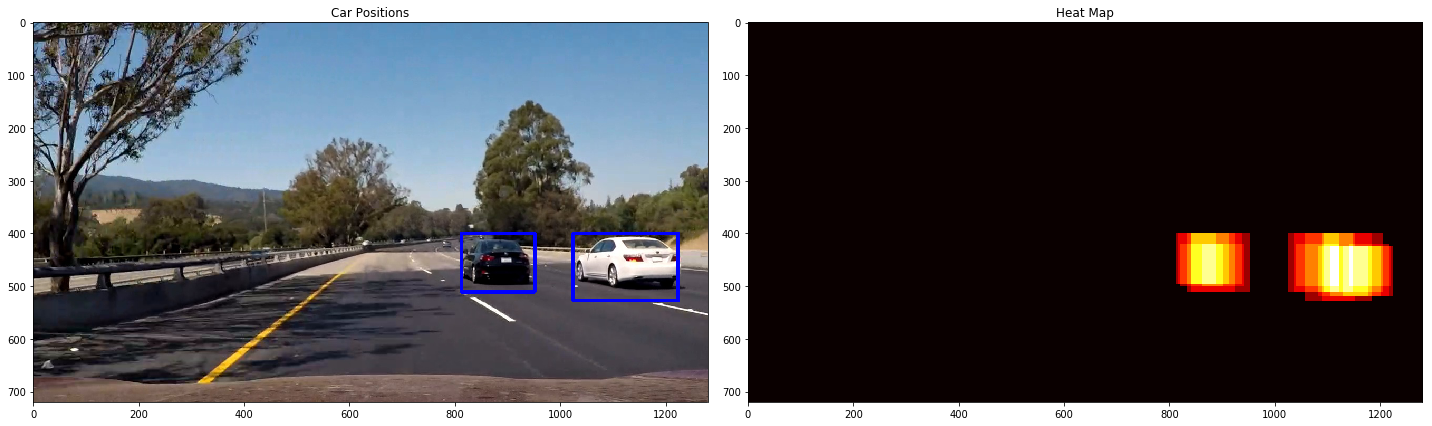

In [88]:
image = mpimg.imread('output_images/test_21.jpg')
res_img = draw_cars_heat(image, True)

In [82]:
from moviepy.editor import VideoFileClip

def processVideo(input_video, output, start=0, end=-1):
    
    clip1 = VideoFileClip(input_video)
    
    clip1 = clip1.subclip(start, end)
    
    out_clip = clip1.fl_image(draw_cars_heat)
    
    out_clip.write_videofile(output,audio=False)

In [92]:
#processVideo('test_video.mp4','test_video_out.mp4')
processVideo('project_video.mp4','project_video_out.mp4')

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1235/1236 [40:38<00:01,  1.96s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 



In [45]:
frame_num = 0
prefix = ''

def dumpFrame(image):
    global frame_num
    global prefix
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite("output_images/%s_%d.jpg" %(prefix, frame_num), image)
    frame_num=frame_num+1
    return image
    
def dumpVideoFrames(input_video, prefixparam):
    frame_num = 0
    global prefix
    prefix = prefixparam
    clip1 = VideoFileClip(input_video)
    out_clip = clip1.fl_image(dumpFrame)
    out_clip.write_videofile("tmp.mp4",audio=False)



dumpVideoFrames('test_video.mp4','test')

[MoviePy] >>>> Building video tmp.mp4
[MoviePy] Writing video tmp.mp4


 97%|█████████▋| 38/39 [00:01<00:00, 29.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: tmp.mp4 

